/home/pawan/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Early stopping at epoch 220
Accuracy: 0.9666666666666667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.92      0.96        13
           2       0.89      1.00      0.94         8

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



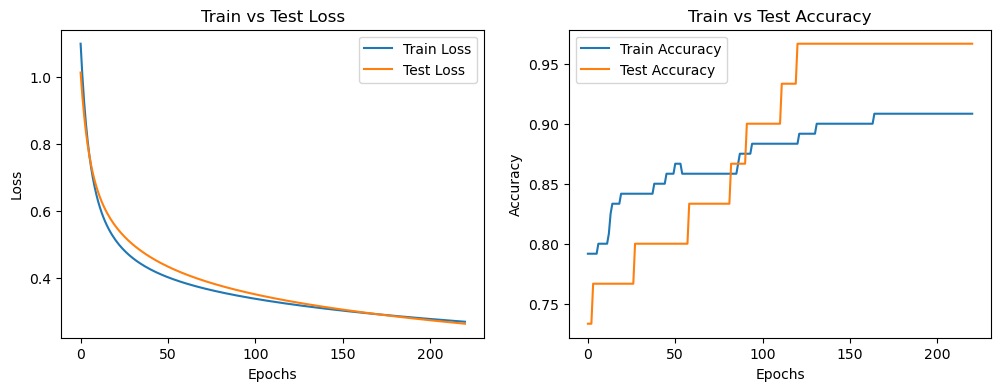

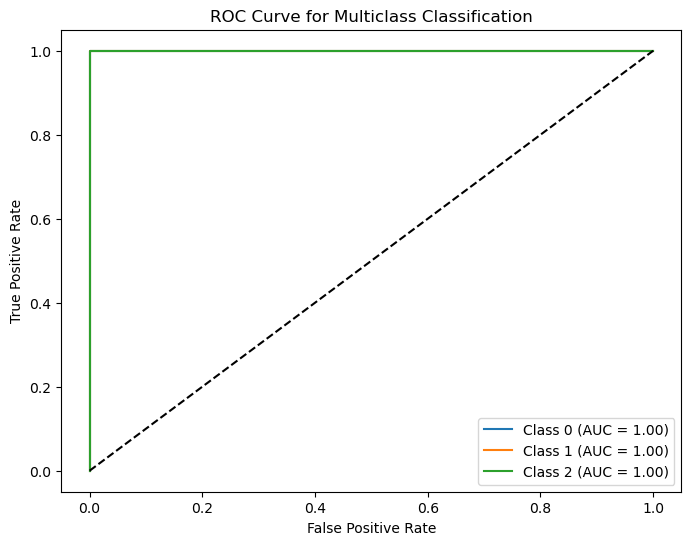

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

class SoftmaxRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000, l2_lambda=0.01, patience=100):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.l2_lambda = l2_lambda  # L2 regularization parameter
        self.patience = patience  # Early stopping patience
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
    
    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-9
        loss = -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))
        loss += self.l2_lambda * np.sum(self.weights**2)  # L2 regularization
        return loss
    
    def fit(self, X_train, y_train, X_test, y_test):
        n_samples, n_features = X_train.shape
        n_classes = y_train.shape[1]
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros((1, n_classes))

        best_test_accuracy = 0
        epochs_without_improvement = 0
        
        for epoch in range(self.n_iters):
            logits = np.dot(X_train, self.weights) + self.bias
            A_train = self._softmax(logits)
            loss = self.compute_loss(y_train, A_train)
            self.train_losses.append(loss)
            
            dw = (1 / n_samples) * np.dot(X_train.T, (A_train - y_train)) + 2 * self.l2_lambda * self.weights
            db = (1 / n_samples) * np.sum(A_train - y_train, axis=0, keepdims=True)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            y_pred_train = self.predict(X_train)
            train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_pred_train)
            self.train_accuracies.append(train_accuracy)
            
            y_pred_test = self.predict(X_test)
            test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_test)
            self.test_accuracies.append(test_accuracy)
            
            test_logits = np.dot(X_test, self.weights) + self.bias
            A_test = self._softmax(test_logits)
            test_loss = self.compute_loss(y_test, A_test)
            self.test_losses.append(test_loss)
            
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
            
            if epochs_without_improvement >= self.patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        return np.argmax(self._softmax(logits), axis=1)

# Example usage
iris = datasets.load_iris()
X, y = iris.data, iris.target
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.reshape(-1, 1))

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

softmax_regressor = SoftmaxRegression(learning_rate=0.1, n_iters=1000, l2_lambda=0.001, patience=100)
softmax_regressor.fit(X_train, y_train, X_test, y_test)

y_pred = softmax_regressor.predict(X_test)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot training and testing loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(softmax_regressor.train_losses, label="Train Loss")
plt.plot(softmax_regressor.test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Test Loss")

# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(softmax_regressor.train_accuracies, label="Train Accuracy")
plt.plot(softmax_regressor.test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train vs Test Accuracy")
plt.show()

# ROC Curve
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = np.dot(X_test, softmax_regressor.weights) + softmax_regressor.bias
A_test = softmax_regressor._softmax(y_score)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], A_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass Classification")
plt.legend()
plt.show()
